In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install gcvit
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 79.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 KB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.9/140.9 KB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 KB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 

In [3]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download vivektalwar1234/grace-data

100% 1.99G/1.99G [01:43<00:00, 21.5MB/s]
100% 1.99G/1.99G [01:43<00:00, 20.6MB/s]


In [8]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!unzip /content/grace-data.zip

Archive:  /content/grace-data.zip
  inflating: grace_data/test/non-suspicious/008449240133_1_left.jpg  
  inflating: grace_data/test/non-suspicious/008449240133_1_others2.jpg  
  inflating: grace_data/test/non-suspicious/008449240133_1_right.jpg  
  inflating: grace_data/test/non-suspicious/008449240133_1_top.jpg  
  inflating: grace_data/test/non-suspicious/020902436774_1_bottom.jpg  
  inflating: grace_data/test/non-suspicious/020902436774_1_left.jpg  
  inflating: grace_data/test/non-suspicious/020902436774_1_others.jpg  
  inflating: grace_data/test/non-suspicious/037550143299_1_left.jpg  
  inflating: grace_data/test/non-suspicious/037550143299_1_right.jpg  
  inflating: grace_data/test/non-suspicious/037550143299_1_top.jpg  
  inflating: grace_data/test/non-suspicious/066524358940_1_left.jpg  
  inflating: grace_data/test/non-suspicious/066524358940_1_top.jpg  
  inflating: grace_data/test/non-suspicious/074834553125_1_left.jpg  
  inflating: grace_data/test/non-suspicious/074834

In [10]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline


In [12]:
import sys
from tqdm import tqdm
import time
import copy


In [13]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T # for simplifying the transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models

In [14]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [15]:
def get_data_loaders(data_dir, batch_size, train = False):
    if train:
        #train
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
            T.RandomErasing(p=0.2, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "train/"), transform = transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        # val/test
        transform = T.Compose([ # We dont need augmentation for test transforms
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "val/"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "test/"), transform=transform)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return val_loader, test_loader, len(val_data), len(test_data)

In [16]:


dataset_path = "/content/grace_data"

train_dir = "/content/grace_data/train"

val_dir = "/content/grace_data/val"

test_dir = "/content/grace_data/test"

In [17]:
import os
(train_loader, train_data_len) = get_data_loaders(dataset_path, 128, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(dataset_path, 32, train=False)

In [18]:
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Layer, Flatten, Embedding, Reshape
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tqdm import tqdm
import plotly.express as px
import torch
import torchvision
from torchvision import transforms as T # for simplifying the transforms
plt.rcParams['font.size'] =  12

In [19]:

classes = get_classes("/content/grace_data/train")
print(classes, len(classes))

['non-suspicious', 'suspicious'] 2


In [20]:
dataloaders = {
    "train": train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train": train_data_len,
    "val": valid_data_len
}


In [21]:
print(len(train_loader), len(val_loader), len(test_loader))

11 13 14


In [22]:
print(train_data_len, valid_data_len, test_data_len)

1344 412 440


In [23]:
# Set up variables for pre-processing
batch_size = 16
epochs = 50
IMG_HEIGHT = 224
IMG_WIDTH = 224

Class names:  ['non-suspicious' 'suspicious']
Found 1344 images belonging to 2 classes.


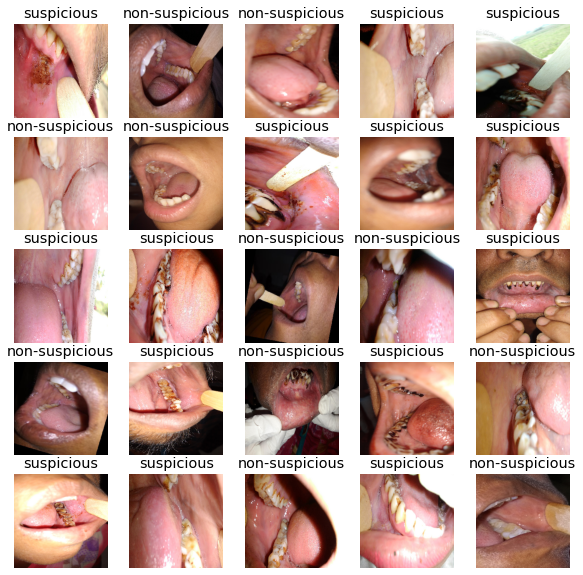

In [24]:

import os
import pathlib
from time import time
# Visualize some images
train_root = pathlib.Path(train_dir)
class_names = sorted([j.name.split('/')[-1] for j in train_root.iterdir()])
class_names = np.array(class_names)
print('Class names: ', class_names)

img_gen = ImageDataGenerator(rescale = 1./255)
sample_train_data_gen = img_gen.flow_from_directory(batch_size = 32,
                                                    directory = train_dir,
                                                    shuffle = True,
                                                    target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                    classes = list(class_names))
                                                 
sample_images, sample_labels = next(sample_train_data_gen)

def show_batch(img_batch, label_batch):
    plt.figure(figsize = (10, 10))
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(sample_images[i])
        plt.title(class_names[sample_labels[i] == 1][0])
        plt.axis('off')
        
show_batch(sample_images, sample_labels)


In [25]:
train_image_generator = ImageDataGenerator(rescale = 1./255,
                                           rotation_range = 45,
                                           width_shift_range = 0.20,
                                           height_shift_range = 0.20,
                                           horizontal_flip = True,
                                           zoom_range = 0.5)

val_image_generator = ImageDataGenerator(rescale = 1./255)
test_image_generator = ImageDataGenerator(rescale = 1./255)

train_data_gen = train_image_generator.flow_from_directory(batch_size = batch_size,
                                                           directory = train_dir,
                                                           shuffle = True,
                                                           target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode = 'categorical')

val_data_gen = val_image_generator.flow_from_directory(batch_size = batch_size,
                                                       directory = val_dir,
                                                       target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                       class_mode = 'categorical')

test_data_gen = test_image_generator.flow_from_directory(test_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 batch_size=batch_size,
                                                 shuffle=False,
                                                 class_mode='categorical')

Found 1344 images belonging to 2 classes.
Found 412 images belonging to 2 classes.
Found 440 images belonging to 2 classes.


In [26]:
# Reference:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2


class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        learning_rate = (
            0.5
            * self.learning_rate_base
            * (
                1
                + tf.cos(
                    self.pi
                    * (tf.cast(step, tf.float32) - self.warmup_steps)
                    / float(self.total_steps - self.warmup_steps)
                )
            )
        )

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

In [27]:
EPOCHS = 50
WARMUP_STEPS = 10
INIT_LR = 0.03
WAMRUP_LR = 0.006
TOTAL_STEPS = 210


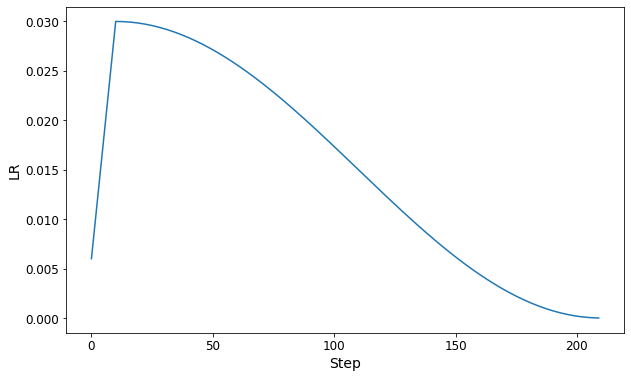

In [28]:
scheduled_lrs = WarmUpCosine(
    learning_rate_base=INIT_LR,
    total_steps=TOTAL_STEPS,
    warmup_learning_rate=WAMRUP_LR,
    warmup_steps=WARMUP_STEPS,
)

lrs = [scheduled_lrs(step) for step in range(TOTAL_STEPS)]
plt.figure(figsize=(10, 6))
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

In [29]:
optimizer = keras.optimizers.Adam(scheduled_lrs)
loss = keras.losses.CategoricalCrossentropy()

In [30]:



# now, for the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [31]:
!pip install vit-keras
!pip install tensorflow-addons


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19579 sha256=d1717437ec9bada5f92eb0cffa3f8d43ef1ea68bf235dda4f8760afe7737e40b
  Stored in directory: /root/.cache/pip/wheels/2d/f0/a8/1094fca7a7e5d0d12ff56e0c64675d72aa5cc81a5fc200e849
Successfully built validators
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
!git clone https://github.com/rishigami/Swin-Transformer-TF.git

Cloning into 'Swin-Transformer-TF'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 44 (delta 15), reused 7 (delta 7), pack-reused 26
Unpacking objects: 100% (44/44), 15.88 KiB | 1.32 MiB/s, done.


In [33]:
import tensorflow as tf
import os
import sys
sys.path.append('/content/Swin-Transformer-TF')
from swintransformer import SwinTransformer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
#from vit_keras import vit, utils, visualize


In [34]:
import cv2
from vit_keras import vit, utils, visualize

In [35]:


IMAGE_SIZE = [224, 224, 3]
NUM_CLASSES = 2

swin_vit = SwinTransformer('swin_base_224', include_top=False, pretrained=True)

model = tf.keras.Sequential()
model.add(tf.keras.Input(shape = IMAGE_SIZE))
model.add(swin_vit)
model.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'))
model.build(IMAGE_SIZE)

321524991/321524991 [==============================] - 10s 0us/step


In [36]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [37]:


model_name = "swin(base).h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 15, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=50, 
                                            verbose=3, 
                                            factor=0.3, 
                                            min_lr=0.00000001)

In [38]:


history = model.fit(train_data_gen,
                    epochs=50,
                    validation_data=val_data_gen,
                    callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
84/84 [==============================] - ETA: 0s - loss: 0.6607 - accuracy: 0.6443
Epoch 1: val_loss improved from inf to 0.56603, saving model to swin(base).h5
84/84 [==============================] - 275s 2s/step - loss: 0.6607 - accuracy: 0.6443 - val_loss: 0.5660 - val_accuracy: 0.7087 - lr: 1.0000e-04
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.5087 - accuracy: 0.7440
Epoch 2: val_loss improved from 0.56603 to 0.49622, saving model to swin(base).h5
84/84 [==============================] - 184s 2s/step - loss: 0.5087 - accuracy: 0.7440 - val_loss: 0.4962 - val_accuracy: 0.7864 - lr: 1.0000e-04
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.4255 - accuracy: 0.8043
Epoch 3: val_loss improved from 0.49622 to 0.44775, saving model to swin(base).h5
84/84 [==============================] - 187s 2s/step - loss: 0.4255 - accuracy: 0.8043 - val_loss: 0.4478 - val_accuracy: 0.7985 - lr: 1.0000e-04
Epoch 4/50
84/84 [=================

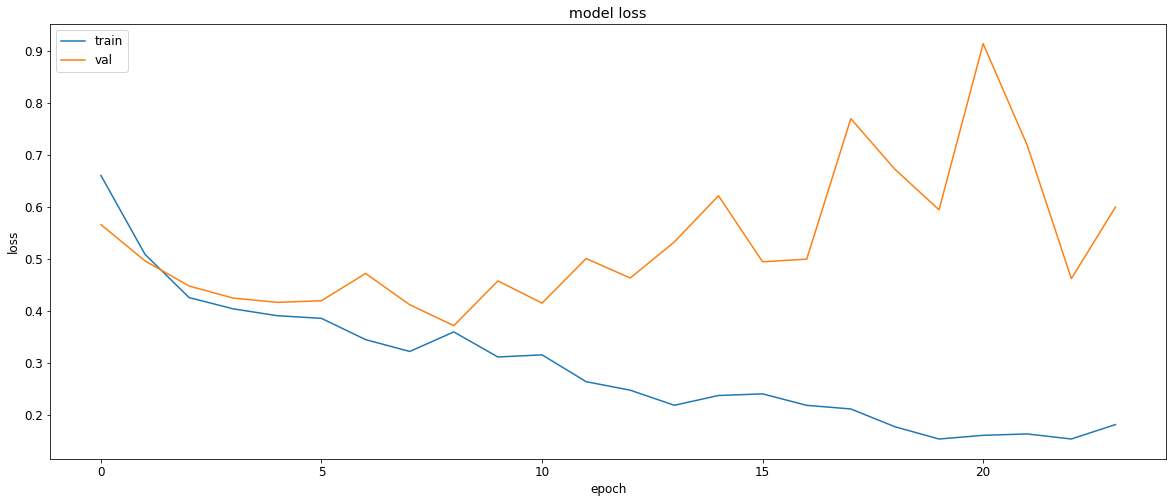

In [39]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

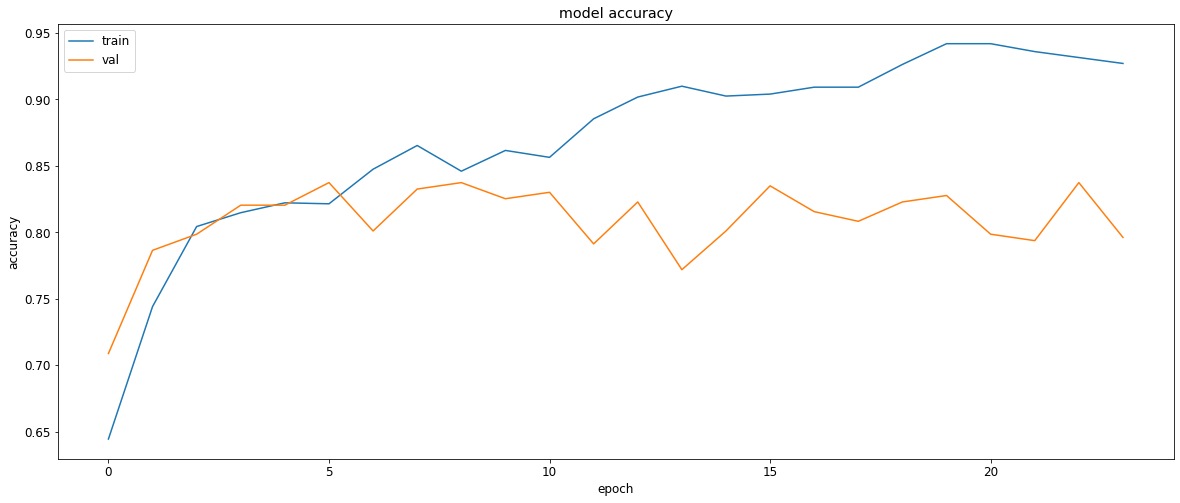

In [40]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [41]:


y_test = test_data_gen.classes
y_preds = model.predict(test_data_gen)
y_pred = np.argmax(y_preds,axis=1)

28/28 [==============================] - 74s 2s/step


In [42]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test,y_pred,target_names = classes))

                precision    recall  f1-score   support

non-suspicious       0.79      0.64      0.71       220
    suspicious       0.70      0.83      0.76       220

      accuracy                           0.73       440
     macro avg       0.74      0.73      0.73       440
  weighted avg       0.74      0.73      0.73       440



In [45]:
!git clone https://github.com/jacobgil/confidenceinterval

Cloning into 'confidenceinterval'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 66 (delta 33), reused 52 (delta 19), pack-reused 0
Unpacking objects: 100% (66/66), 18.20 KiB | 1.07 MiB/s, done.


In [46]:
import tensorflow as tf
import os
import sys
sys.path.append('/content/confidenceinterval')


from confidenceinterval import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split

In [47]:
auc, ci = roc_auc_score(y_test, y_pred, confidence_level=0.95)
print(auc)
print(ci)

0.7340909
(0.6936452477990915, 0.7745366007269094)


In [48]:
from confidenceinterval.bootstrap import bootstrap_ci, bootstrap_methods

In [54]:
from confidenceinterval import precision_score, recall_score, f1_score

In [49]:
import statsmodels
from statsmodels.stats.proportion import proportion_confint
from sklearn.metrics import confusion_matrix
from scipy.stats import bootstrap
from typing import List, Callable
from functools import partial
import numpy as np
from scipy.stats import norm


In [50]:
from confidenceinterval.bootstrap import bootstrap_ci, bootstrap_methods

In [55]:
print(precision_score(y_test, y_pred, confidence_level=0.95, average ='micro'))
f1_score(y_test, y_pred, confidence_level=0.95, average='macro')

(0.7340909090909091, (0.6928086677617931, 0.7753731504200252))


(0.7317618368577627, (0.6552726858017384, 0.8082509879137871))

In [43]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


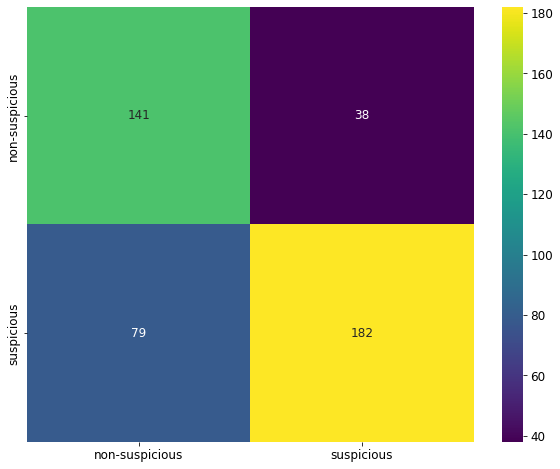

In [56]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_pred,y_test),annot=True,fmt='.3g',xticklabels=classes,yticklabels=classes,cmap='viridis')
plt.show()

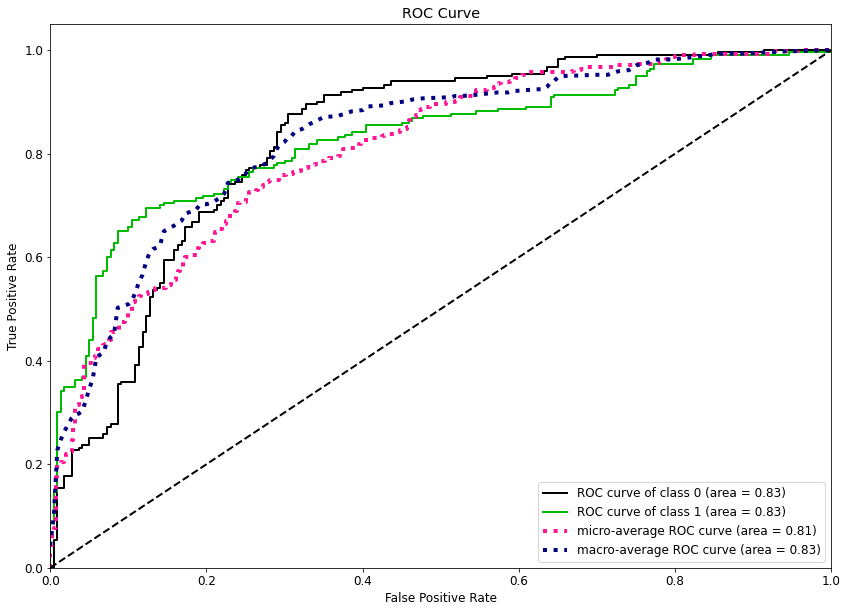

In [57]:
import scikitplot as skplt
import matplotlib.pyplot as plt

# y_test = # ground truth labels
# y_pred = # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_test, y_preds, figsize=(14,10), 
                            #  curves=('micro'),
                             title='ROC Curve')
plt.show()

In [58]:

from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred)

0.7340909090909089

In [59]:
tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
print(tn)
print(fp)
print(fn)
print(tp)

141
79
38
182


In [60]:
# Specify the class ID for which you want to obtain false negatives
class_id = 1

# Convert the predicted and ground truth labels to boolean arrays
y_pred_bool = (y_pred > 0.5)  # Assuming binary classification task with threshold of 0.5
y_test_bool = (y_test == class_id)

# Obtain the indices of the false negatives for the given class ID
false_neg_indices = np.where((y_pred_bool != y_test_bool) & (y_test_bool == 1))[0]

# Get the corresponding false negative filenames from the test_data_gen
false_neg_filenames = []
for index in false_neg_indices:
    # Set the batch index and sample index within the batch
    batch_index = index // test_data_gen.batch_size
    sample_index = index % test_data_gen.batch_size

    # Get the filepaths for the current batch
    filepaths = test_data_gen.filepaths[batch_index * test_data_gen.batch_size : (batch_index + 1) * test_data_gen.batch_size]

    # Get the false negative filename
    filename = filepaths[sample_index]

    false_neg_filenames.append(filename)

# Print the number of false negatives for the given class ID
print(f"Class {class_id} has {len(false_neg_filenames)} false negatives.")

# Print the filenames of the false negatives for the given class ID
print("Filenames of false negatives:")
for filename in false_neg_filenames:
    print(filename)

Class 1 has 38 false negatives.
Filenames of false negatives:
/content/grace_data/test/suspicious/025145455822_1_bottom.jpg
/content/grace_data/test/suspicious/035581113357_1_others.jpg
/content/grace_data/test/suspicious/037550143299_1_bottom.jpg
/content/grace_data/test/suspicious/055884005064_1_bottom.jpg
/content/grace_data/test/suspicious/065840191068_1_bottom.jpg
/content/grace_data/test/suspicious/065840191068_1_others.jpg
/content/grace_data/test/suspicious/068176939157_1_left.jpg
/content/grace_data/test/suspicious/075125308486_1_bottom.jpg
/content/grace_data/test/suspicious/075125308486_1_left.jpg
/content/grace_data/test/suspicious/079739991149_1_left.jpg
/content/grace_data/test/suspicious/148876096229_1_others.jpg
/content/grace_data/test/suspicious/161394464117_1_bottom.jpg
/content/grace_data/test/suspicious/167392725307_1_bottom.jpg
/content/grace_data/test/suspicious/201621813327_1_bottom.jpg
/content/grace_data/test/suspicious/242717878291_1_left.jpg
/content/grace_d

In [61]:
# Specify the class ID for which you want to obtain false positives
class_id = 1

# Convert the predicted and ground truth labels to boolean arrays
y_pred_bool = (y_pred > 0.5)  # Assuming binary classification task with threshold of 0.5
y_test_bool = (y_test == class_id)

# Obtain the indices of the false positives for the given class ID
false_pos_indices = np.where((y_pred_bool != y_test_bool) & (y_test_bool == 0) & (y_pred_bool == 1))[0]

# Get the corresponding false positive filenames from the test_data_gen
false_pos_filenames = []
for index in false_pos_indices:
    # Set the batch index and sample index within the batch
    batch_index = index // test_data_gen.batch_size
    sample_index = index % test_data_gen.batch_size

    # Get the filepaths for the current batch
    filepaths = test_data_gen.filepaths[batch_index * test_data_gen.batch_size : (batch_index + 1) * test_data_gen.batch_size]

    # Get the false positive filename
    filename = filepaths[sample_index]

    false_pos_filenames.append(filename)

# Print the number of false positives for the given class ID
print(f"Class {class_id} has {len(false_pos_filenames)} false positives.")

# Print the filenames of the false positives for the given class ID
print("Filenames of false positives:")
for filename in false_pos_filenames:
    print(filename)

Class 1 has 79 false positives.
Filenames of false positives:
/content/grace_data/test/non-suspicious/008449240133_1_left.jpg
/content/grace_data/test/non-suspicious/008449240133_1_others2.jpg
/content/grace_data/test/non-suspicious/020902436774_1_others.jpg
/content/grace_data/test/non-suspicious/037550143299_1_right.jpg
/content/grace_data/test/non-suspicious/074834553125_1_left.jpg
/content/grace_data/test/non-suspicious/074834553125_1_right.jpg
/content/grace_data/test/non-suspicious/074834553125_1_top.jpg
/content/grace_data/test/non-suspicious/075125308486_1_right.jpg
/content/grace_data/test/non-suspicious/075125308486_1_top.jpg
/content/grace_data/test/non-suspicious/079739991149_1_right.jpg
/content/grace_data/test/non-suspicious/117914854749_1_bottom.jpg
/content/grace_data/test/non-suspicious/117914854749_1_others.jpg
/content/grace_data/test/non-suspicious/122602125749_1_bottom.jpg
/content/grace_data/test/non-suspicious/122602125749_1_others.jpg
/content/grace_data/test/no